In [ ]:
## https://github.com/process-intelligence-solutions/pm4py/blob/release/notebooks/3_process_discovery.ipynb

In [ ]:
import uuid
from IPython.display import display, HTML

def create_hide_button():
    unique_id = str(uuid.uuid4())
    display(HTML('''
        <script>
        function toggle_output(button_id) {
            var output_area = document.getElementById(button_id).parentElement.parentElement.nextElementSibling;
            var button = document.getElementById(button_id);
            if (output_area.style.display === "none") {
                output_area.style.display = "block";
                button.innerHTML = "Hide Output";
            } else {
                output_area.style.display = "none";
                button.innerHTML = "Show Output";
            }
        }
        </script>
    '''))

    button_id = f"button_{unique_id}"
    display(HTML(f'''
        <button id="{button_id}" onclick="toggle_output('{button_id}')">Show Output</button>
        <script>
            document.getElementById('{button_id}').parentElement.parentElement.nextElementSibling.style.display = 'none';
        </script>
    '''))

In [ ]:
from IPython.display import display, HTML

display(HTML('''<style>
    .jp-CodeCell .jp-InputArea {display: none;} /* Hide only code cells */
</style>'''))

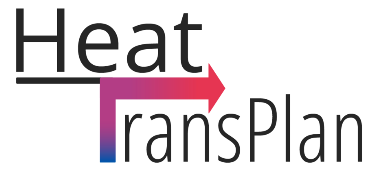


<div style="text-align: center; font-size: 50px;">
    <b>Exploratory Data Analysis</b>
</div>

In [ ]:
import sys
sys.path.append('../../../')

import pandas as pd
import random
import itertools
import os
import numpy as np
from datetime import datetime, timedelta
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

import simpy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import chardet
import plotly.io as pio
import chardet#
import pandas as pd
from utils.utility import *
from pathlib import Path

pio.renderers.default='notebook'
pd.options.mode.chained_assignment = None

# Join the datasets

In [ ]:
# Define the path to the current file's location
current_path = Path(__file__).resolve().parent if '__file__' in globals() else Path().resolve()

# Navigate to the 'data/bronze/aixit' folder relative to the current path
files_folder_bronze = current_path.parent.parent.parent.parent / 'data' / 'bronze' / 'eckes_granini'

In [ ]:
df = pd.read_parquet(files_folder_bronze / 'df_sensor_joined.parquet')


df_sensors = df.copy()
sensors_columns = df_sensors.drop(columns='datetime').columns.tolist()

#df_sensors

In [ ]:
df = pd.read_csv(files_folder_bronze / 'AufträgeMeldungen_merged.csv', sep=',')

# Make all column names lower case and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_').dropna(how = 'all')

# Convert relevant columns to datetime
for col in ['starttime_activity', 'endtime_activity', 'starttime_order']:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col])

df_events = df.copy()
#df

In [ ]:
import pandas as pd

# Assume your dfs are already loaded

# 1. Drop events without a time, and sort
df_events_nonull = df_events.dropna(subset=['starttime_activity']).sort_values('starttime_activity').reset_index(drop=True)

# 2. Sort sensors by time
df_sensors = df_sensors.sort_values('datetime').reset_index(drop=True)

# 3. merge_asof for future event (forward)
df = pd.merge_asof(
    df_sensors,
    df_events_nonull,
    left_on='datetime',
    right_on='starttime_activity',
    direction='forward',
    allow_exact_matches=False  # Don't match if they're exactly equal
)
# 4. Mark where event changed
df['activity_change'] = (df['starttime_activity'] != df['starttime_activity'].shift(1)).astype(int)

# 5. Keep only what you need
df_joined = df#[['datetime', 'starttime_activity', 'activity_change']]

#display(df_joined)

# Get the weather

Wetter für Koordinaten des Werkes abrufen 52.858994493455356, 9.689264924618607

In [ ]:
file = "weather.csv"
file_path = files_folder_bronze / file

# Copy original DataFrame
df = df_joined.copy()

getweather = True

if getweather == True:
    # Define latitude, longitude, and date range from hipp
    latitude = 52.858994493455356
    longitude = 9.689264924618607
    start_date = df['datetime'].min().strftime('%Y-%m-%d')
    end_date = df['datetime'].max().strftime('%Y-%m-%d')

    # Fetch weather data
    df_weather = get_weather(start_date, end_date, latitude, longitude)

    # Save the weather data to the CSV file
    df_weather.to_csv(file_path, index=False)
else: 

    # Load the data back
    df_weather = pd.read_csv(file_path)

# Display loaded data

df_weather = df_weather.rename(columns={'timestamp_utc': 'datetime'})
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])

# Aggregation

Aggregierung der Daten pro Minute und Stunde für Visualisierungen

In [ ]:
df_joined.columns

In [ ]:
#### The variables are resampled per hour
pd.set_option('display.max_rows', 10)

all_columns = df_joined.columns

# Define columns to aggregate with 'first'
first_columns = ['ordernumber', 'bf_product', 'bf_number', 'starttime_order',
       'endtime_order', 'actualquantity', 'sfg_product', 'sfg_brix-density',
       'unnamed:_8', 'objektbezeichnung', 'kommende_meldung',
       'starttime_activity', 'endtime_activity', 'activityname',
       'activity_change']

# Define columns to aggregate with 'sum'
sum_columns = []

# Define columns to aggregate with 'mean' (all others not in first_columns or sum_columns)
mean_columns = [col for col in all_columns if col not in first_columns + sum_columns]

# Create a dictionary for aggregation methods
agg_dict = {col: 'mean' for col in mean_columns}
agg_dict.update({col: 'first' for col in first_columns})
agg_dict.update({col: 'sum' for col in sum_columns})  # Sum aggregation for specific columns

# Resample by 5 minutes and apply custom aggregation
df_resampled_1_min = df_joined.resample('15min', on='datetime').agg(agg_dict).reset_index(drop=True)

#df_resampled_1_min.isna().sum().sum()

In [ ]:
# Define columns to aggregate with 'mean' (all others not in first_columns or sum_columns)
mean_columns = [col for col in all_columns if col not in first_columns + sum_columns]
# Create a dictionary for aggregation methods
agg_dict = {col: 'mean' for col in mean_columns}
agg_dict.update({col: 'first' for col in first_columns})
agg_dict.update({col: 'sum' for col in sum_columns})  # Sum aggregation for specific columns
# Resample by 5 minutes and apply custom aggregation
df_resampled_1H = df_joined.resample('h', on='datetime').agg(agg_dict).reset_index(drop=True)
df_resampled_1H['datetime'] = pd.to_datetime(df_resampled_1H['datetime']).dt.floor('h')

df_resampled_1H

In [ ]:
df_resampled_1H_weather = df_resampled_1H.merge(df_weather, on='datetime', how='left')

# Visualize the all the variables together for one day in min aggregation

Auf die Legende klicken, um einzelne Variablen auszuwählen.

In [ ]:
import pandas as pd
import plotly.express as px

df = df_resampled_1_min.copy()

# Define the date range with hours
day_start = '2024-08-01 00:00:00'
day_end = '2024-08-01 18:00:00'

# Ensure the datetime column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Filter the DataFrame for the specified date range
df= df[(df['datetime'] >= pd.to_datetime(day_start)) & 
                 (df['datetime'] < pd.to_datetime(day_end))]

single_day = '2024-08-01'  # Replace with the desired date
df['datetime'] = pd.to_datetime(df['datetime'])  # Ensure the datetime column is in datetime format
df = df[df['datetime'].dt.date == pd.to_datetime(single_day).date()]

# Assuming 'df' is your DataFrame
# Ensure the 'datetime' column is of type datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Exclude non-numeric columns for plotting
numeric_columns = df.select_dtypes(include=[float, int]).columns

# Create the Plotly figure
fig = px.line(df, x='datetime', y=numeric_columns,
              labels={col: col for col in numeric_columns},
              title='Interactive Visualization of Variables')

# Update layout to make columns clickable
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Value',
    legend_title='Variables',
    hovermode='x unified',
)


# Show the plot
fig.show()

# Visualize the all the variables together per hour

Auf die Legende klicken, um einzelne Variablen auszuwählen.

In [ ]:
import pandas as pd
import plotly.express as px

df = df_resampled_1H_weather.copy()

# Assuming 'df' is your DataFrame
# Ensure the 'datetime' column is of type datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Exclude non-numeric columns for plotting
numeric_columns = df.select_dtypes(include=[float, int]).columns

# Create the Plotly figure
fig = px.line(df, x='datetime', y=numeric_columns,
              labels={col: col for col in numeric_columns},
              title='Interactive Visualization of Variables')

# Update layout to make columns clickable
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Value',
    legend_title='Variables',
    hovermode='x unified',
)

# Show the plot
fig.show()

In [ ]:
df_resampled_1H_weather.columns

# Visualize the all the variables together scaling them from 0 to 1

Auf die Legende klicken, um einzelne Variablen auszuwählen.

In [ ]:
df_resampled_1H_weather.columns

In [ ]:
import pandas as pd
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

# Assuming 'df_resampled_1H' is your original DataFrame
df = df_resampled_1H_weather.copy()

# Select only numeric columns for scaling, excluding 'datetime'
columns_to_scale = df.select_dtypes(include=[float, int]).columns

# Scale the variables to the range [0, 1]
scaler = MinMaxScaler()
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

# Create the Plotly figure
fig = px.line(df, x='datetime', y=columns_to_scale,
              labels={col: col for col in columns_to_scale},
              title='Interactive Visualization of Scaled Variables',
              hover_data={'activityname': True, 'objektbezeichnung': True})

# Update layout to make columns clickable
fig.update_layout(
    xaxis_title='Datetime',
    yaxis_title='Scaled Value',
    legend_title='Variables',
    hovermode='x unified',
)

# Show the plot
fig.show()

# Correlation matrix

In [ ]:
import pandas as pd
import plotly.express as px



relevant_columns = ['temp_Auslauf_EG_(WT2)_5s', 'temp_Einlauf_EG_(WT_2)_5s',
       'flow_Kuehlturmwasser_30120FT701_5s', 'flow_Kaltwasser_(WT7)_5s',
       'Kuehlturmwassertemp_(WT6)_5s', 'Kaltwassertemp_(WT_7)_5s',
       'nach_Kuehler_(WT7)_5s', 'temp_nach_Kuehlturmkuehler_(WT6)_5s',
       'Fuellstand_Steriltank_30140LT001_5s',
       'Fuellstand_Steriltank_30141LT001_5s', 'flow_Dampf_WT3a/5a)_5s',
       'flow_Heisswasser_30120FT721(WT5a)_5s',
       'temp_nach_WR2,_vor_Druckerhoehungspumpe_(WT4)_5s',
       'temp_nach_Erhitzer_(WT5)_5s', 'temp_nach_WR2_(WT2)_5s',
       'temp_nach_Austauscher_2_(WT4)_5s', 'Druck_HW_Anwaermer_(WT3a)_5s',
       'temp_HW_Anwaermer_(WT3a)_5s', 'temp_Produkt_Einlauf_30110TT001_1h',
       'flow_Vorlaufpumpe_30110FT301_1h', 'temp_vor_Vorwärmer_(WT_2)_1h',
       #'ordernumber', 'bf_product', 'bf_number', 'starttime_order',
       #'endtime_order', 'actualquantity', 'sfg_product', 'sfg_brix-density',
       #'unnamed:_8', 'objektbezeichnung', 'kommende_meldung',
       #'starttime_activity', 'endtime_activity', 'activityname',
       #'activity_change', 
       'temperature_2m', 'relative_humidity_2m',
       'apparent_temperature', 'precipitation', 'wind_speed_10m',
       'wind_direction_100m', 'global_tilted_irradiance']

# Assuming df_resampled is already defined and contains your data
df = df_resampled_1H_weather.copy()

df = df[relevant_columns]

# Exclude non-numeric columns
numeric_df = df.select_dtypes(include=[float, int])

# state 1: Calculate the correlation matrix
corr_matrix = numeric_df.corr()

# state 2: Plot the heatmap using Plotly
fig = px.imshow(corr_matrix, 
                text_auto=".1f",  # Round the correlation coefficients to one decimal place
                color_continuous_scale='RdBu',  # Red to blue color scale
                labels=dict(x="Variables", y="Variables", color="Correlation"),
                title="Correlation Matrix Heatmap",
                width=1200,  # Increase the width
                height=1200)  # Increase the height


#print(' Correlation for 1 hour span')
# state 3: Show the plot
fig.show()



# Process Mining

In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming df_resampled_1min is already defined
process_df = df_resampled_1_min[['datetime', 'activityname']].reset_index()

# Count the number of minutes each status was activated
status_counts_l01 = process_df['activityname'].value_counts()
#status_counts_l02 = process_df['status_name_l02'].value_counts()

# Convert minutes to hours
status_counts_l01_hours = status_counts_l01 / 60
#status_counts_l02_hours = status_counts_l02 / 60

# Create the figure
fig = make_subplots(rows=1, cols=1, subplot_titles=('Minutes each status was activated'))

# Add the bar plot for status_name_l01
fig.add_trace(
    go.Bar(
        x=status_counts_l01.index, 
        y=status_counts_l01.values, 
        name='L01',
        hovertemplate='Status: %{x}<br>Minutes: %{y}<br>Hours: %{customdata:.2f}<extra></extra>',
        customdata=status_counts_l01_hours.values
    ),
    row=1, col=1
)

# Update layout
fig.update_layout(title_text="Minutes each status was activated")

# Show the plot
fig.show()

In [ ]:
import pm4py
import matplotlib.pyplot as plt
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# Your existing code
df = df_joined[['datetime', 'activityname']].reset_index()
df['index'] = 1
df = df[['datetime', 'activityname', 'index']]
# Rename columns
df.columns = ['timestamp_start', 'activity', 'case_id']

df = df[df['activity'] != df['activity'].shift(-1)]

df['case_id'] = df['case_id'] + (df['activity'] == 'Rework Step-004 = Dosieren').cumsum()

# Rest of your code

# Add a new column 'timestamp_end' calculated as the start time of the next activity
df['timestamp_end'] = df['timestamp_start'].shift(-1)
df['recipe'] = 'A'
df = df.dropna(subset=['timestamp_end'])

event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='activity', timestamp_key='timestamp_start')
#event_log

In [ ]:
event_log['activity'].value_counts()

In [ ]:
import pm4py
import matplotlib.pyplot as plt
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer

# Visualization for status_name
df = event_log

event_log = pm4py.format_dataframe(df, case_id='case_id', activity_key='activity', timestamp_key='timestamp_start')
event_log['recipe'] = 'A'
map_ = pm4py.discover_heuristics_net(event_log)
gviz = hn_visualizer.apply(map_)
hn_visualizer.save(gviz, "heuristics_net.png")

# Display the image
fig, ax = plt.subplots(figsize=(30, 30))  # Adjust the width and height as needed

# Load and display the image
img = plt.imread("heuristics_net.png")
ax.imshow(img)
ax.axis('off')  # Hide the axis
ax.set_title('Status Name')

# Save the combined image
plt.savefig(files_folder_bronze/"heuristics_net_status_name_eckes_granini.png")

# Show the plot
plt.show()